# Multi-Model Bias Evaluation Analysis
## Does Gemini 3 Favor Its Own Answers?

This notebook analyzes the results from our bias evaluation experiment comparing Claude 4.5, GPT 5.1, and Gemini.


In [3]:
import sys
sys.path.insert(0, '../../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from analysis import (
    load_and_merge_data,
    calculate_top1_preference,
    calculate_average_scores,
    calculate_category_preference,
    calculate_tier_preference,
    detect_self_bias,
    run_statistical_tests,
    generate_summary_report
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")


✓ Imports successful


## 1. Load Data

Update the file paths below to point to your generated data, or let it automatically find the latest files.


In [4]:
# Use the downloaded MT-Bench data from HuggingFace
ANSWERS_PATH = "data/answers/answers_mt_bench.json"
JUDGMENTS_PATH = "data/judgments/judgments_mt_bench.json"

print(f"Using answers: {ANSWERS_PATH}")
print(f"Using judgments: {JUDGMENTS_PATH}")

df = load_and_merge_data(ANSWERS_PATH, JUDGMENTS_PATH)
print(f"\nLoaded {len(df)} judgment records")
print(f"Unique prompts: {df['prompt_id'].nunique()}")
print(f"Judges: {df['judge'].unique().tolist()}")
display(df.head())


Using answers: data/answers/answers_mt_bench.json
Using judgments: data/judgments/judgments_mt_bench.json

Loaded 2879 judgment records
Unique prompts: 80
Judges: ['gpt_fast', 'gemini_thinking', 'gemini_fast', 'claude_fast', 'claude_thinking', 'gpt_thinking']


,prompt_id,category,answer_id,model_vendor,model_tier,judge,rank,score,is_top_ranked
0,writing_081,writing,ans_writing_081_gpt_thinking,gpt,thinking,gpt_fast,1,10,True
1,writing_081,writing,ans_writing_081_gpt_fast,gpt,fast,gpt_fast,2,9,False
2,writing_081,writing,ans_writing_081_claude_fast,claude,fast,gpt_fast,3,8,False
3,writing_081,writing,ans_writing_081_claude_thinking,claude,thinking,gpt_fast,4,7,False
4,writing_081,writing,ans_writing_081_gemini_fast,gemini,fast,gpt_fast,5,5,False


## 2. Summary Report

Generate overall bias summary for Gemini as judge.


In [5]:
report = generate_summary_report(df, target_vendor='gemini')
print(report)


BIAS EVALUATION SUMMARY REPORT

Target Vendor: GEMINI
Judge: gemini_thinking
Total judgments analyzed: 80

----------------------------------------------------------------------
TOP-1 PREFERENCE RATES
----------------------------------------------------------------------
Claude      26.25% (21/80)
Gpt         42.50% (34/80)
Gemini      31.25% (25/80)

----------------------------------------------------------------------
AVERAGE SCORES BY VENDOR AND TIER
----------------------------------------------------------------------
Claude     (fast    ): 7.30 ± 2.23
Claude     (thinking): 7.96 ± 1.84
Gemini     (fast    ): 6.01 ± 3.41
Gemini     (thinking): 7.55 ± 2.75
Gpt        (fast    ): 7.05 ± 3.26
Gpt        (thinking): 8.47 ± 2.21

----------------------------------------------------------------------
SELF-BIAS DETECTION
----------------------------------------------------------------------

GEMINI judge ranks GEMINI #1: 31.25% of the time
Other judges rank GEMINI #1: 19.75% (average)



## 3. Visualization: Top-1 Preference Rates


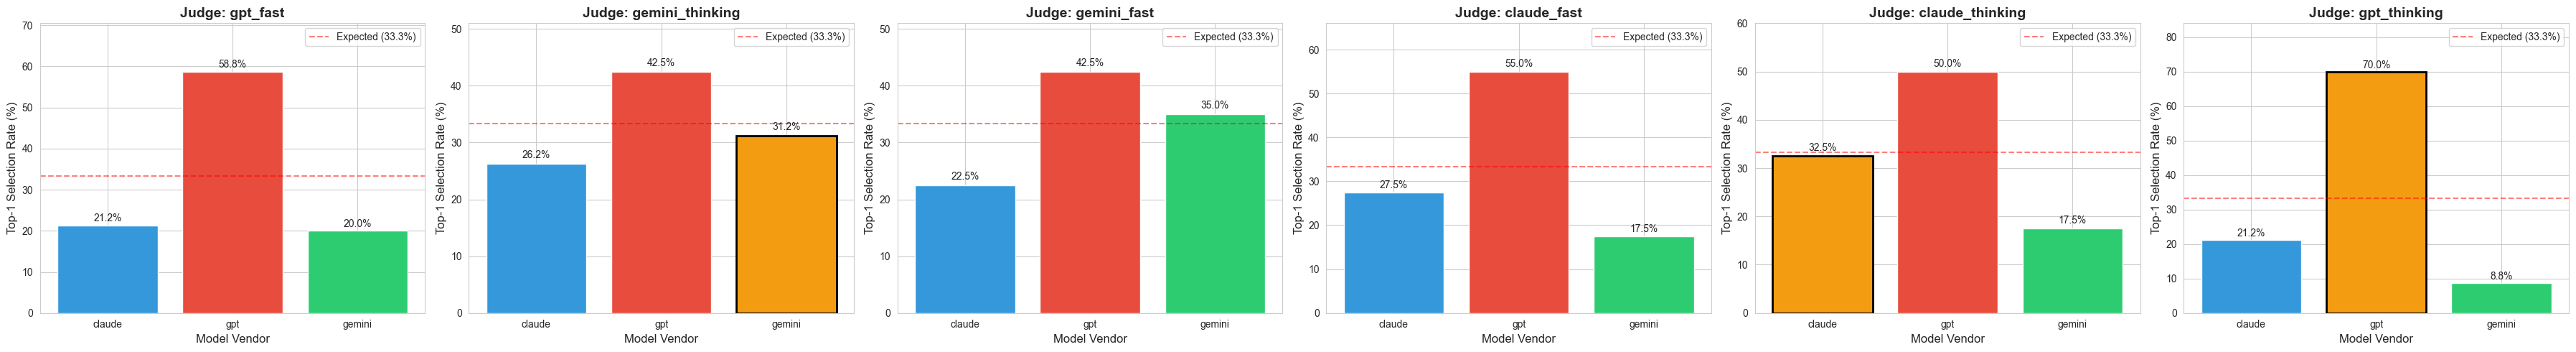

In [6]:
judges = df['judge'].unique()

fig, axes = plt.subplots(1, len(judges), figsize=(6*len(judges), 5))
if len(judges) == 1:
    axes = [axes]

for i, judge in enumerate(judges):
    top1_prefs = calculate_top1_preference(df, judge)
    
    ax = axes[i]
    bars = ax.bar(top1_prefs['vendor'], top1_prefs['top1_percentage'], 
                   color=['#3498db', '#e74c3c', '#2ecc71'])
    
    if judge.endswith('_thinking'):
        vendor = judge.split('_')[0]
        if vendor in top1_prefs['vendor'].values:
            idx = top1_prefs[top1_prefs['vendor'] == vendor].index[0]
            bars[idx].set_color('#f39c12')
            bars[idx].set_edgecolor('black')
            bars[idx].set_linewidth(2)
    
    ax.set_title(f'Judge: {judge}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model Vendor', fontsize=12)
    ax.set_ylabel('Top-1 Selection Rate (%)', fontsize=12)
    ax.set_ylim([0, max(50, top1_prefs['top1_percentage'].max() * 1.2)])
    ax.axhline(y=33.33, color='red', linestyle='--', alpha=0.5, label='Expected (33.3%)')
    ax.legend()
    
    for j, (vendor, pct) in enumerate(zip(top1_prefs['vendor'], top1_prefs['top1_percentage'])):
        ax.text(j, pct + 1, f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('data/results/top1_preferences.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Average Scores by Vendor and Tier


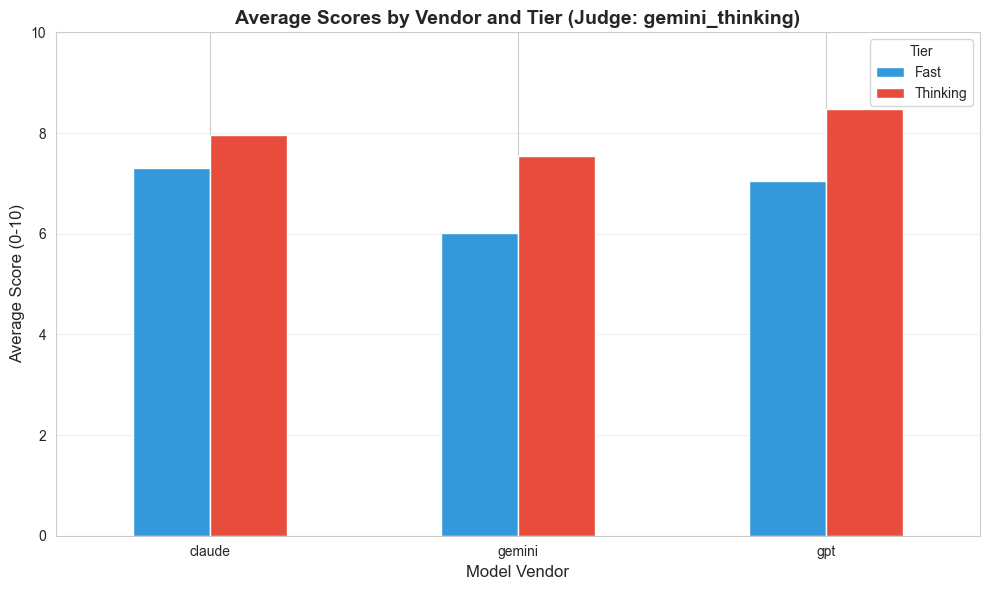


Average Scores:
vendor     tier  mean_score  std_score  count
claude     fast      7.3000   2.229832     80
claude thinking      7.9625   1.844895     80
gemini     fast      6.0125   3.414392     80
gemini thinking      7.5500   2.750834     80
   gpt     fast      7.0500   3.260426     80
   gpt thinking      8.4750   2.210304     80


In [7]:
target_judge = 'gemini_thinking'
scores_df = calculate_average_scores(df, target_judge)

# Pivot for visualization
pivot = scores_df.pivot(index='vendor', columns='tier', values='mean_score')

fig, ax = plt.subplots(figsize=(10, 6))
pivot.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_title(f'Average Scores by Vendor and Tier (Judge: {target_judge})', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Model Vendor', fontsize=12)
ax.set_ylabel('Average Score (0-10)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Tier', labels=['Fast', 'Thinking'])
ax.set_ylim([0, 10])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('data/results/average_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAverage Scores:")
print(scores_df.to_string(index=False))


## 5. Category-wise Preference Analysis


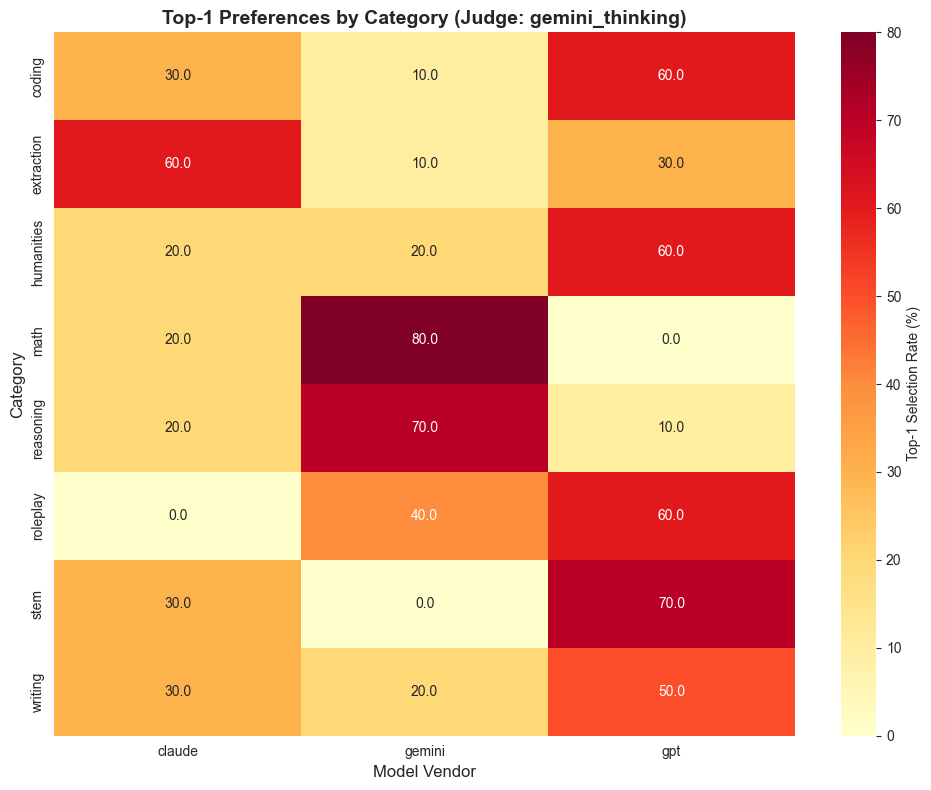


Category Preferences:
  category model_vendor  count  total  percentage
    coding       claude      3     10        30.0
    coding       gemini      1     10        10.0
    coding          gpt      6     10        60.0
extraction       claude      6     10        60.0
extraction       gemini      1     10        10.0
extraction          gpt      3     10        30.0
humanities       claude      2     10        20.0
humanities       gemini      2     10        20.0
humanities          gpt      6     10        60.0
      math       claude      2     10        20.0
      math       gemini      8     10        80.0
 reasoning       claude      2     10        20.0
 reasoning       gemini      7     10        70.0
 reasoning          gpt      1     10        10.0
  roleplay       gemini      4     10        40.0
  roleplay          gpt      6     10        60.0
      stem       claude      3     10        30.0
      stem          gpt      7     10        70.0
   writing       claude    

In [8]:
target_judge = 'gemini_thinking'
category_prefs = calculate_category_preference(df, target_judge)

# Pivot for heatmap
pivot = category_prefs.pivot(index='category', columns='model_vendor', values='percentage')
pivot = pivot.fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Top-1 Selection Rate (%)'}, ax=ax)
ax.set_title(f'Top-1 Preferences by Category (Judge: {target_judge})', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Model Vendor', fontsize=12)
ax.set_ylabel('Category', fontsize=12)

plt.tight_layout()
plt.savefig('data/results/category_preferences.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCategory Preferences:")
print(category_prefs.to_string(index=False))


## 6. Tier Preference Analysis (Fast vs Thinking)


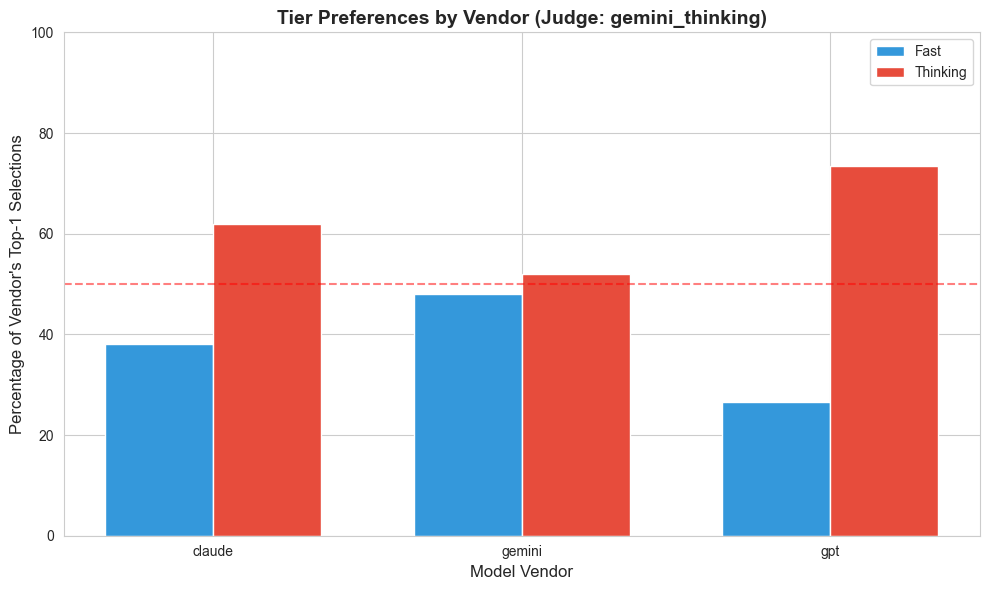


Tier Preferences:
model_vendor model_tier  count  vendor_total  percentage
      claude       fast      8            21   38.095238
      claude   thinking     13            21   61.904762
      gemini       fast     12            25   48.000000
      gemini   thinking     13            25   52.000000
         gpt       fast      9            34   26.470588
         gpt   thinking     25            34   73.529412


In [9]:
target_judge = 'gemini_thinking'
tier_prefs = calculate_tier_preference(df, target_judge)

fig, ax = plt.subplots(figsize=(10, 6))

# Group by vendor
vendors = tier_prefs['model_vendor'].unique()
x = np.arange(len(vendors))
width = 0.35

fast_data = []
thinking_data = []

for vendor in vendors:
    vendor_data = tier_prefs[tier_prefs['model_vendor'] == vendor]
    fast = vendor_data[vendor_data['model_tier'] == 'fast']['percentage'].values
    thinking = vendor_data[vendor_data['model_tier'] == 'thinking']['percentage'].values
    fast_data.append(fast[0] if len(fast) > 0 else 0)
    thinking_data.append(thinking[0] if len(thinking) > 0 else 0)

ax.bar(x - width/2, fast_data, width, label='Fast', color='#3498db')
ax.bar(x + width/2, thinking_data, width, label='Thinking', color='#e74c3c')

ax.set_title(f'Tier Preferences by Vendor (Judge: {target_judge})', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Model Vendor', fontsize=12)
ax.set_ylabel('Percentage of Vendor\'s Top-1 Selections', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(vendors)
ax.legend()
ax.set_ylim([0, 100])
ax.axhline(y=50, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('data/results/tier_preferences.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTier Preferences:")
print(tier_prefs.to_string(index=False))


## 7. Self-Bias Detection

Compare how different judges rank each vendor's answers.


In [10]:
# Detect self-bias for each vendor
vendors = ['claude', 'gpt', 'gemini']
bias_results = {}

for vendor in vendors:
    bias_results[vendor] = detect_self_bias(df, vendor)
    
    if 'bias_analysis' in bias_results[vendor]:
        ba = bias_results[vendor]['bias_analysis']
        print(f"\n{vendor.upper()} Self-Bias Analysis:")
        print(f"  {vendor.upper()} judge ranks {vendor.upper()} #1: {ba['target_judge_rate']*100:.2f}%")
        print(f"  Other judges rank {vendor.upper()} #1: {ba['other_judges_avg_rate']*100:.2f}%")
        print(f"  Bias difference: {ba['bias_percentage_points']:+.2f} percentage points")
        
        if abs(ba['bias_difference']) > 0.1:
            if ba['bias_difference'] > 0:
                print("  ⚠️  POTENTIAL SELF-BIAS DETECTED")
            else:
                print("  ⚠️  POTENTIAL SELF-PENALTY DETECTED")
        else:
            print("  ✓ No significant self-bias")



CLAUDE Self-Bias Analysis:
  CLAUDE judge ranks CLAUDE #1: 32.50%
  Other judges rank CLAUDE #1: 23.75%
  Bias difference: +8.75 percentage points
  ✓ No significant self-bias

GPT Self-Bias Analysis:
  GPT judge ranks GPT #1: 70.00%
  Other judges rank GPT #1: 49.75%
  Bias difference: +20.25 percentage points
  ⚠️  POTENTIAL SELF-BIAS DETECTED

GEMINI Self-Bias Analysis:
  GEMINI judge ranks GEMINI #1: 31.25%
  Other judges rank GEMINI #1: 19.75%
  Bias difference: +11.50 percentage points
  ⚠️  POTENTIAL SELF-BIAS DETECTED


## 8. Statistical Significance Tests


In [11]:
# Run statistical tests for Gemini
stat_tests = run_statistical_tests(df, target_vendor='gemini')

print("Statistical Tests for Gemini Self-Bias:")
print("\n1. Chi-Square Goodness of Fit Test")
print(f"   Null Hypothesis: {stat_tests['chi_square_test']['null_hypothesis']}")
print(f"   χ² = {stat_tests['chi_square_test']['chi2_statistic']:.3f}")
print(f"   p-value = {stat_tests['chi_square_test']['p_value']:.4f}")
print(f"   Significant at α=0.05: {stat_tests['chi_square_test']['significant_at_0.05']}")

print("\n2. Binomial Test")
print(f"   Null Hypothesis: {stat_tests['binomial_test']['null_hypothesis']}")
print(f"   Observed rate: {stat_tests['binomial_test']['observed_rate']*100:.2f}%")
print(f"   Expected rate: {stat_tests['binomial_test']['expected_rate']*100:.2f}%")
print(f"   p-value = {stat_tests['binomial_test']['p_value']:.4f}")
print(f"   Significant at α=0.05: {stat_tests['binomial_test']['significant_at_0.05']}")


Statistical Tests for Gemini Self-Bias:

1. Chi-Square Goodness of Fit Test
   Null Hypothesis: Judge preferences are uniform across vendors
   χ² = 3.325
   p-value = 0.1897
   Significant at α=0.05: False

2. Binomial Test
   Null Hypothesis: gemini ranked #1 at expected rate (1/3)
   Observed rate: 31.25%
   Expected rate: 33.33%
   p-value = 0.6927
   Significant at α=0.05: False


## 9. Cross-Judge Comparison

If multiple judges were used, compare their preferences.


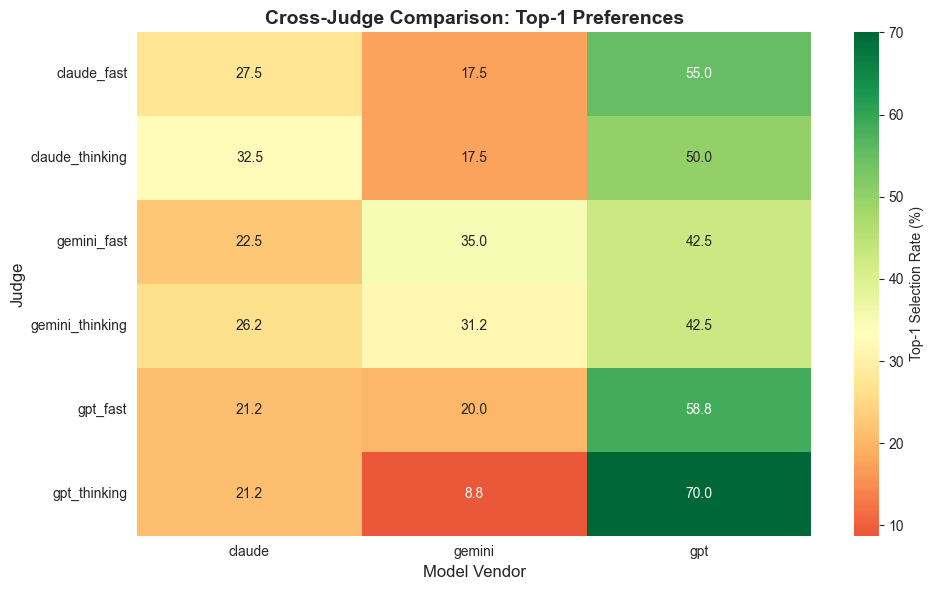


Cross-Judge Comparison:
vendor           claude  gemini    gpt
judge                                 
claude_fast       27.50   17.50  55.00
claude_thinking   32.50   17.50  50.00
gemini_fast       22.50   35.00  42.50
gemini_thinking   26.25   31.25  42.50
gpt_fast          21.25   20.00  58.75
gpt_thinking      21.25    8.75  70.00


In [12]:
judges = df['judge'].unique()

if len(judges) > 1:
    # Create comparison matrix
    comparison_data = []
    
    for judge in judges:
        top1_prefs = calculate_top1_preference(df, judge)
        for _, row in top1_prefs.iterrows():
            comparison_data.append({
                'judge': judge,
                'vendor': row['vendor'],
                'top1_percentage': row['top1_percentage']
            })
    
    comp_df = pd.DataFrame(comparison_data)
    pivot = comp_df.pivot(index='judge', columns='vendor', values='top1_percentage')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=33.33,
                cbar_kws={'label': 'Top-1 Selection Rate (%)'}, ax=ax)
    ax.set_title('Cross-Judge Comparison: Top-1 Preferences', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Model Vendor', fontsize=12)
    ax.set_ylabel('Judge', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('data/results/cross_judge_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nCross-Judge Comparison:")
    print(pivot)
else:
    print("Only one judge used. Run with multiple judges for comparison.")


## 10. Export Results

Save analysis results to CSV files for further exploration.


In [13]:
# Export main dataframe
df.to_csv('data/results/analysis_data.csv', index=False)
print("✓ Main analysis data saved to data/results/analysis_data.csv")

# Export summary statistics
target_judge = 'gemini_thinking'
top1_prefs = calculate_top1_preference(df, target_judge)
top1_prefs.to_csv('data/results/top1_preferences.csv', index=False)
print("✓ Top-1 preferences saved to data/results/top1_preferences.csv")

scores_df = calculate_average_scores(df, target_judge)
scores_df.to_csv('data/results/average_scores.csv', index=False)
print("✓ Average scores saved to data/results/average_scores.csv")

category_prefs = calculate_category_preference(df, target_judge)
category_prefs.to_csv('data/results/category_preferences.csv', index=False)
print("✓ Category preferences saved to data/results/category_preferences.csv")

print("\n✓ All results exported successfully!")


✓ Main analysis data saved to data/results/analysis_data.csv
✓ Top-1 preferences saved to data/results/top1_preferences.csv
✓ Average scores saved to data/results/average_scores.csv
✓ Category preferences saved to data/results/category_preferences.csv

✓ All results exported successfully!


## Conclusions

Based on the analysis above, summarize your findings:

1. **Overall Bias**: Does Gemini show self-preference?
2. **Tier Effects**: Does bias differ between Fast and Thinking tiers?
3. **Category Effects**: Is bias stronger in subjective vs objective tasks?
4. **Cross-Judge Comparison**: Do all judges show similar self-bias patterns?

Add your interpretations and conclusions here after running the full analysis.
